In [1]:
import os
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from datetime import datetime, timedelta, date
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils import normalize_image, get_sequences, plot_image, plot_images
from dust_analysis import (left_pass_pairs, right_pass_pairs, read_raw_image, read_rectified_image, 
    print_seg_performance, print_seg_dust_performance, get_seg_dust_performance_by_time, get_seg_dust_performance_by_camera_pod)

In [2]:
def read_csvs(pred_root_dir, model, labeled_dataset):
    pred_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'output.csv'))
    if not 'state' in pred_df:
        pred_df['state'] = pred_df['result_state']
    dust_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'dust_ratio.csv'))
    print(labeled_dataset, pred_df.shape, dust_df.shape)
    df = pred_df[['unique_id', 'state', 'camera_location', 'operation_time']].merge(dust_df, on='unique_id')
    all_cameras = {'Front Pod': ['T01', 'T02', 'T03', 'T04'], 'Right Pod': ['T05', 'T06', 'T07', 'T08'], 'Rear Pod': ['T09', 'T10', 'T11', 'T12'], 'Left Pod': ['T13', 'T14', 'T15', 'T16']}
    all_cameras = {c: pod for pod, cameras in all_cameras.items() for c in cameras}
    df['pod'] = df.camera_location.apply(lambda c: all_cameras[c])
    return df

def read_data_csvs_and_get_time(data_root_dir, unlabeled_datasets, labeled_datasets, use_ds, day_night_split):
    dfs = {'day': [], 'dawn_dusk': [], 'night': []}
    datasets = {}
    for di in use_ds:
        raw_ds, labeled_ds = unlabeled_datasets[di], labeled_datasets[di]
        raw_df = pd.read_csv(os.path.join(data_root_dir, raw_ds, 'annotations.csv'))
        labeled_df = pd.read_csv(os.path.join(data_root_dir, labeled_ds, 'master_annotations.csv'))
        dn_split = day_night_split[di]
        datasets[di] = [labeled_ds, labeled_df]
        if isinstance(dn_split, str):
            dfs[dn_split].append(labeled_df)
            print(f'load {raw_ds}, get {dn_split} data with {labeled_df.shape}')
        else:
            for dn_split, seq_ids in dn_split.items():
                seq_dfs = get_sequences(raw_df, interval=60)
                dn_raw_df = pd.concat([seq_df for i,seq_df in enumerate(seq_dfs) if i in seq_ids], ignore_index=True)
                dn_df = labeled_df[labeled_df.id.isin(dn_raw_df.id)]
                dfs[dn_split].append(dn_df)
                print(f'load {raw_ds}, get {dn_split} data with {dn_df.shape}')
    dfs = {k: pd.concat(v, ignore_index=True) for k,v in dfs.items()}
    for dn_split, dn_df in dfs.items():
        print(f'{dn_split}: {dn_df.shape}')
    return dfs, datasets

def print_seg_dust_performance(df, model_desc):
    tp_df = df[(df.state == 'true_positive')]
    tn_df = df[(df.state == 'true_negative')]
    fp_df = df[(df.state == 'false_positive')]
    fn_df = df[(df.state == 'false_negative')]
    tp_dust_df = df[df.unique_id.isin(tp_df.unique_id)]
    tn_dust_df = df[df.unique_id.isin(tn_df.unique_id)]
    fp_dust_df = df[df.unique_id.isin(fp_df.unique_id)]
    fn_dust_df = df[df.unique_id.isin(fn_df.unique_id)]
    recall = len(tp_df) / (len(tp_df) + len(fn_df) + 1e-6)
    productivity = len(tn_df) / (len(tn_df) + len(fp_df) + 1e-6)
    print(f'{model_desc}: TP {len(tp_df)}, TN {len(tn_df)}, FP {len(fp_df)}, FN {len(fn_df)}, Recall {recall:.4f}, Productivity {productivity:.4f}')
    print(f'{model_desc} dust: TP {tp_dust_df.total_averaged_dust_conf.mean():.2f}, TN {tn_dust_df.total_averaged_dust_conf.mean():.2f}, FP {fp_dust_df.total_averaged_dust_conf.mean():.2f}, FN {fn_dust_df.total_averaged_dust_conf.mean():.2f}')


## Human in dust data analysis

In [3]:
data_root_dir = '/data/jupiter/datasets'
unlabeled_datasets = [
    "halo_human_in_dust_day_collection_may29",
    "halo_human_in_dust_night_collection_june03",  # for lying down humans
    "halo_human_in_dust_night_collection_june03_2",
    "halo_human_in_dust_day_collection_back_june05",
]
labeled_datasets = [
    "halo_human_in_dust_day_collection_may29_human_labeled_stereo",
    "halo_human_in_dust_night_collection_june03_human_labeled_stereo",
    "halo_human_in_dust_night_collection_june03_2_human_labeled_stereo",
    "halo_human_in_dust_day_collection_back_june05_human_labeled_stereo",
]
day_night_split = ['day', 'dawn_dusk', {'dawn_dusk': list(range(0, 9)), 'night': list(range(9, 20))}, 'day']
use_ds = [0, 1, 2, 3]
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
models = [
    'all_rev2_rev1_lying_down_sitting_headlights_round_2_25_ep_prod_weights_10_lo_10_tr_dust_0601',
    # 'all_rev2_rev1_lying_down_sitting_headlights_round_2_25_ep_prod_weights_dust_0601',
]

# # load full and labeled dataset
# di = 2
# # raw_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[di], 'master_annotations.csv'))
# # raw_df['camera_pair'] = raw_df.unique_id.apply(lambda s: s[-7:])
# stereo_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[di], 'master_annotations.csv'))
# stereo_df['camera_pair'] = stereo_df.unique_id.apply(lambda s: s[-7:])
# print(stereo_df.shape)

# # load pred and dust df
# mi = 0
# df = read_csvs(pred_root_dir, models[mi], labeled_datasets[di])
# # compare performance
# print_seg_dust_performance(df, model_desc='model')

# load data csvs
data_dfs, datasets = read_data_csvs_and_get_time(data_root_dir, unlabeled_datasets, labeled_datasets, use_ds, day_night_split)

# model predictions
mi = 0
pred_dfs = [read_csvs(pred_root_dir, models[mi], labeled_datasets[di]) for di in use_ds]
pred_df = pd.concat(pred_dfs, ignore_index=True)
print(pred_df.shape)

<ipython-input-3-335a1f683e63>:37: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  data_dfs, datasets = read_data_csvs_and_get_time(data_root_dir, unlabeled_datasets, labeled_datasets, use_ds, day_night_split)


load halo_human_in_dust_day_collection_may29, get day data with (5968, 277)
load halo_human_in_dust_night_collection_june03, get dawn_dusk data with (2111, 211)
load halo_human_in_dust_night_collection_june03_2, get dawn_dusk data with (6370, 278)
load halo_human_in_dust_night_collection_june03_2, get night data with (5469, 278)
load halo_human_in_dust_day_collection_back_june05, get day data with (3511, 277)
day: (9479, 278)
dawn_dusk: (8481, 278)
night: (5469, 278)
halo_human_in_dust_day_collection_may29_human_labeled_stereo (5968, 16) (5968, 7)
halo_human_in_dust_night_collection_june03_human_labeled_stereo (2111, 16) (2111, 7)
halo_human_in_dust_night_collection_june03_2_human_labeled_stereo (11839, 16) (11839, 7)
halo_human_in_dust_day_collection_back_june05_human_labeled_stereo (3511, 16) (3511, 7)
(23429, 11)


In [4]:
pred_df.head(2)

,unique_id,state,camera_location,operation_time,id,gt_dust_ratio,total_averaged_dust_conf,total_thresholded_dust_ratio,masked_avg_dust_conf,masked_dust_ratio,pod
0,66595e558b545d525752cfb2_T02_T03,true_positive,T02,daytime,66595e558b545d525752cfb2,0.0,0.124939,0.036865,0.152748,0.047904,Front Pod
1,66595eea568146714ce37514_T02_T03,true_positive,T02,daytime,66595eea568146714ce37514,0.0,0.125615,0.028809,0.125125,0.029940,Front Pod


In [5]:
day_df = pred_df[pred_df.id.isin(data_dfs['day'].id)]
dawn_dusk_df = pred_df[pred_df.id.isin(data_dfs['dawn_dusk'].id)]
night_df = pred_df[pred_df.id.isin(data_dfs['night'].id)]
all_ds_df = pd.concat(data_dfs.values(), ignore_index=True)
print(day_df.shape, dawn_dusk_df.shape, night_df.shape, all_ds_df.shape)

# pods = ['Front Pod', 'Left Pod', 'Right Pod', 'Rear Pod']
pods = [['Front Pod'], ['Left Pod', 'Right Pod'], ['Rear Pod']]
times = ['day', 'dawn_dusk', 'night']
pod_dfs = [pred_df[pred_df.pod.isin(pod)] for pod in pods]
# day_dfs = [pod_df[pod_df.id.isin(data_dfs['day'].id)] for pod_df in pod_dfs]
# dawn_dusk_dfs = [pod_df[pod_df.id.isin(data_dfs['dawn_dusk'].id)] for pod_df in pod_dfs]
# night_dfs = [pod_df[pod_df.id.isin(data_dfs['night'].id)] for pod_df in pod_dfs]

(9479, 11) (8481, 11) (5469, 11) (23429, 278)


day [646, 3152, 5681]
dawn_dusk [6645, 1459, 377]
night [1579, 2184, 1706]


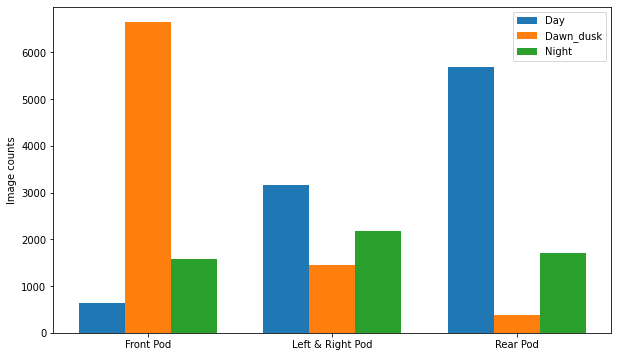

day [277, 1299, 632]
dawn_dusk [1433, 1194, 185]
night [1195, 1100, 933]


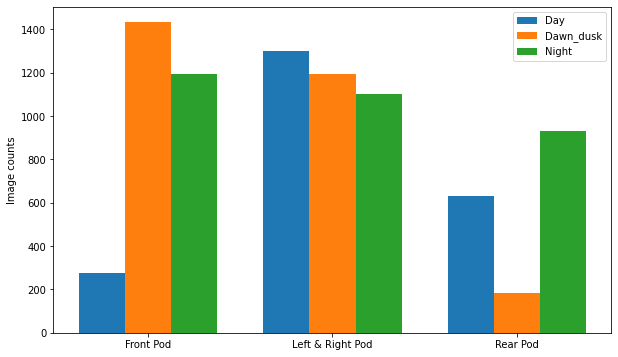

In [6]:
def plot_counts_pod_vs_time(pred_df):
    plt.figure(1, figsize=(10, 6))
    idx = np.arange(len(pods))
    width = 0.25
    bars = []
    for ti, t in enumerate(times):
        counts = [len(pred_df[(pred_df.pod.isin(pod)) & (pred_df.id.isin(data_dfs[t].id))]) for pod in pods]
        print(t, counts)
        bar = plt.bar(idx+width*ti, counts, width)
        bars.append(bar)
    plt.xticks(idx+width, ['Front Pod', 'Left & Right Pod', 'Rear Pod'])
    plt.ylabel('Image counts')
    plt.legend(bars, ['Day', 'Dawn_dusk', 'Night'])
    plt.show()

plot_counts_pod_vs_time(pred_df)
plot_counts_pod_vs_time(pred_df[pred_df.total_averaged_dust_conf > 0.05])

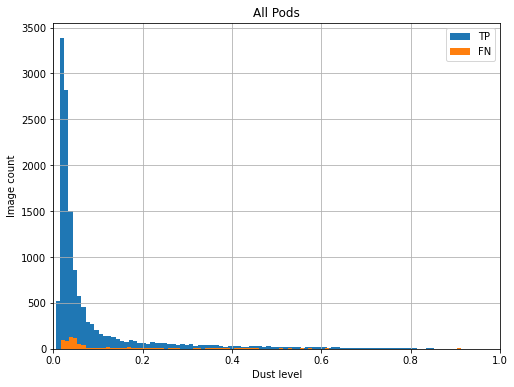

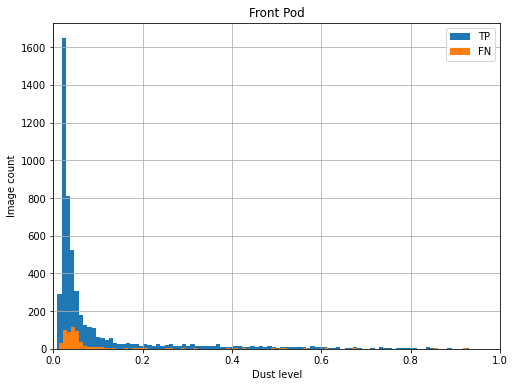

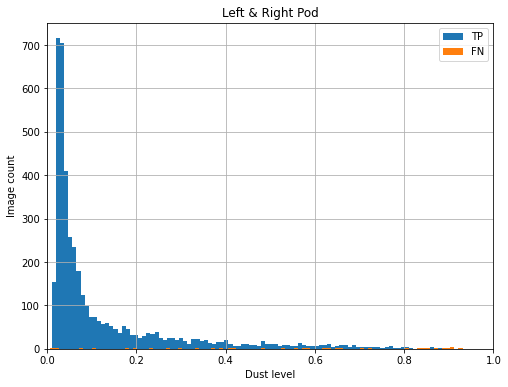

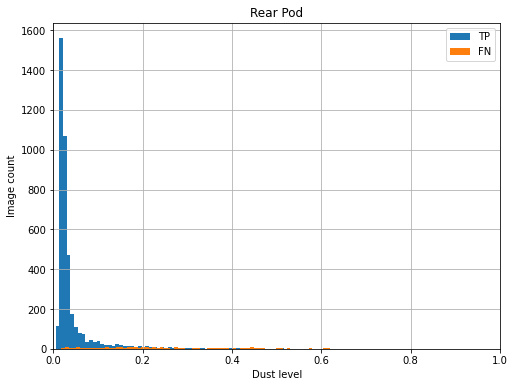

In [7]:
def plot_dust_ratio_vs_pred_state(df, title):
    tp_df = df[df.state == 'true_positive']
    fn_df = df[df.state == 'false_negative']
    plt.figure(1, figsize=(8, 6))
    tp_df.total_averaged_dust_conf.hist(bins=100)
    fn_df.total_averaged_dust_conf.hist(bins=100)
    plt.legend(['TP', 'FN'])
    plt.title(title)
    plt.xlim(0.0, 1.0)
    plt.xlabel('Dust level')
    plt.ylabel('Image count')
    plt.show()

plot_dust_ratio_vs_pred_state(pred_df, 'All Pods')
plot_dust_ratio_vs_pred_state(pod_dfs[0], 'Front Pod')
plot_dust_ratio_vs_pred_state(pod_dfs[1], 'Left & Right Pod')
plot_dust_ratio_vs_pred_state(pod_dfs[2], 'Rear Pod')

## Visualize data

In [21]:
total_df = all_ds_df.drop(columns=['id', 'state', 'camera_location', 'operation_time']).merge(pred_df, on='unique_id')
total_df.shape

(21318, 284)

In [50]:
df2 = total_df[(total_df.total_averaged_dust_conf > 0.25) & (total_df.state == 'true_positive') & (total_df.pod == 'Front Pod')]
# df2 = total_df[(total_df.total_averaged_dust_conf > 0.25) & (total_df.state == 'false_negative') & (total_df.pod == 'Front Pod')]
# df2 = df[(df.total_averaged_dust_conf > 0.25) & (df.state == 'false_negative')]
# df2 = stereo_df[stereo_df.unique_id.isin(df2.unique_id)]
df2.shape

(583, 284)

665faa6e939f2b85f3505e3c_T02_T03 T02 2024-06-04T05:51:43.956000 nightime 0.29084778


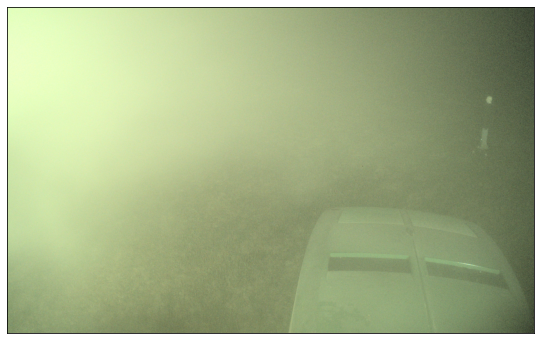

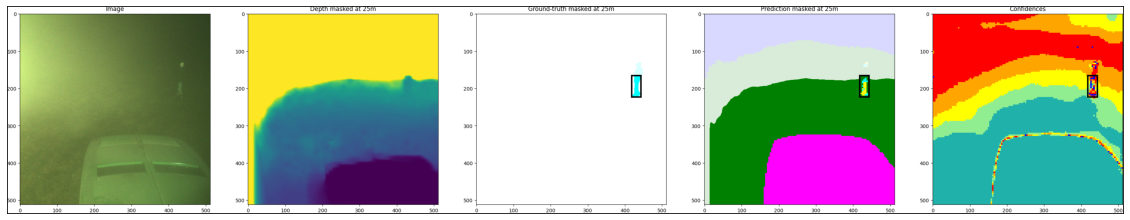

665fc41c952576d7372df549_T02_T04 T02 2024-06-04T05:42:05.535000 nightime 0.73530465


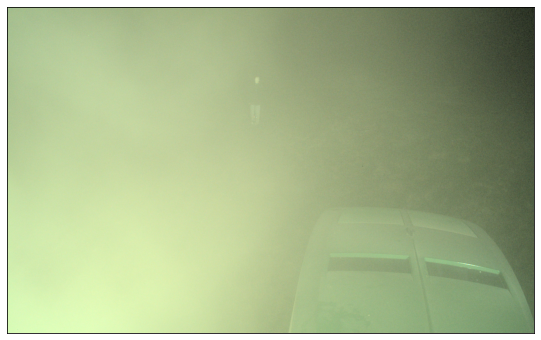

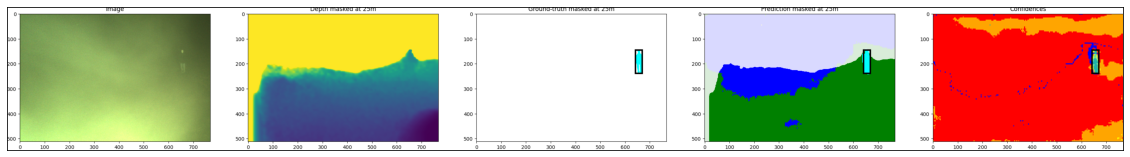

665fb6a3a3c642262e367ba2_T02_T04 T02 2024-06-04T03:31:06.069000 dawn_dusk 0.34487626


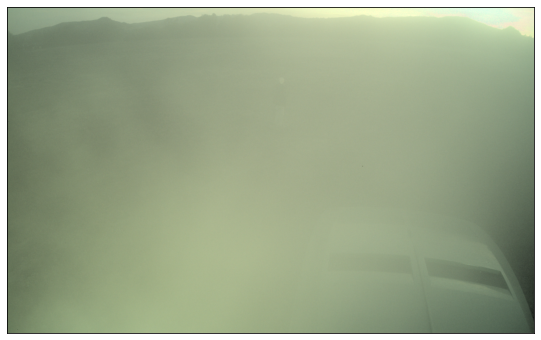

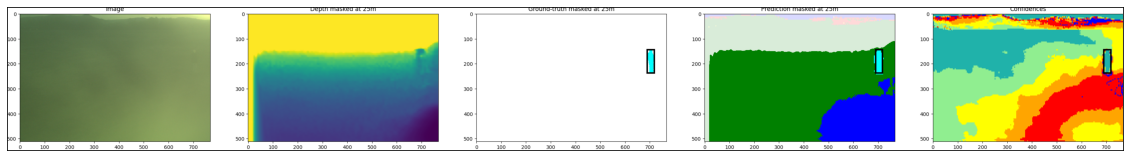

665fb9e79c60a8591a25cbbe_T02_T03 T02 2024-06-04T03:30:29.439000 dawn_dusk 0.3602449


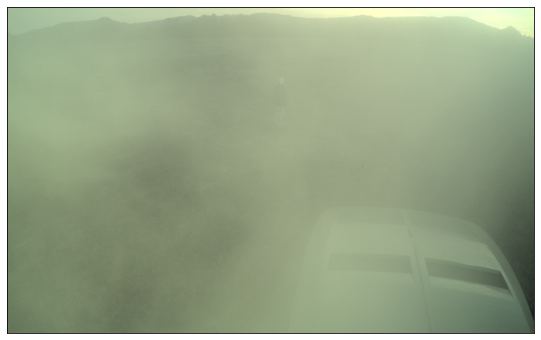

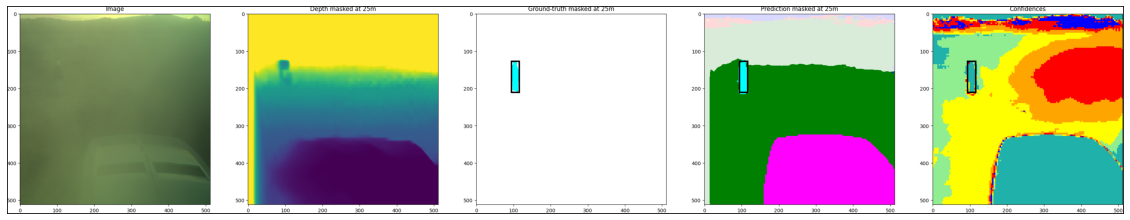

665fbfdf3a683d3d9f842fd5_T02_T04 T02 2024-06-04T05:40:55.605000 nightime 0.5174201


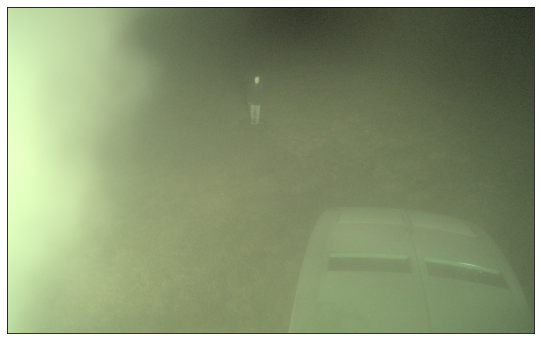

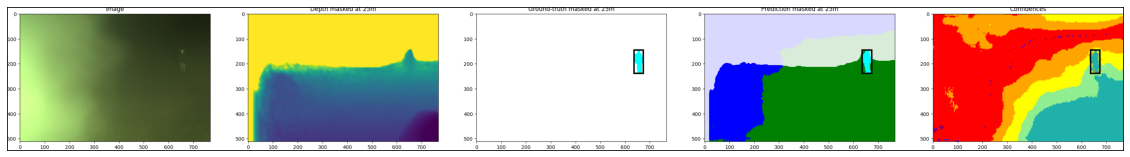

In [54]:
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['65e9b50a06198505e2a58145_T14_T15', '65e9beba4875033da619fb9b_T05_T07'])]
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
sub_df = df2.sample(5)
show_image, show_label = False, False
show_debayered_rgb, show_raw_label = True, False
show_pred_result = True

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    # print(row.unique_id, row.pred_dust_ratio)
    for di, (labeled_dataset, labeled_df) in datasets.items():
        if len(labeled_df[labeled_df.unique_id == row.unique_id]) > 0:
            break
    print(row.unique_id, row.camera_location, row.collected_on, row.operation_time, row.total_averaged_dust_conf)
    if show_image:
        data_path = os.path.join(data_root_dir, labeled_dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, hdr_mode=True, return_8_bit=True)
        plot_image(img_norm)

    if show_debayered_rgb:
        # print(os.path.join(data_root_dir, labeled_dataset, row.artifact_debayeredrgb_0_save_path))
        image = imageio.imread(os.path.join(data_root_dir, labeled_dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(data_root_dir, labeled_dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 25)

    if show_raw_label:
        label = imageio.imread(os.path.join(data_root_dir, labeled_dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 25)

    if show_pred_result:
        result_path = os.path.join(pred_root_dir, models[mi], labeled_dataset, 'output_visualization', row.unique_id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))